# MLP
Like MLP_205 with K=5.

Epochs=200.

Now exclude the middle from train and test.

In [47]:
from datetime import datetime
print(datetime.now())

2023-03-28 14:38:35.884439


In [48]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [49]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TAILS_TRAIN  = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TRAIN = True
FILTER_MIDDLE_TEST  = True
FILTER_NONE         = False

Python 3.9.16
sklearn 1.2.2


In [50]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [51]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [52]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [53]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [54]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-28 14:38:37.486833
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 64)                65664     
                                                                 
 dense_97 (Dense)            (None, 64)                4160      
                                                                 
 dense_98 (Dense)            (None, 64)                4160      
                                                                 
 dense_99 (Dense)            (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [55]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [56]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_NONE or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_NONE or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-28 14:38:37.682419
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-28 14:38:56.348664

Training # 1 1
2023-03-28 14:38:56.349901
2023-03-28 14:38:56.349976
Discriminator ZERO -1
Train 1:0 1043:1031 50.29%
Computed class weights: {0: 1.005819592628516, 1: 0.9942473633748802}
Valid 1:0 280:262 51.66%
FIT
2023-03-28 14:38:56.422245


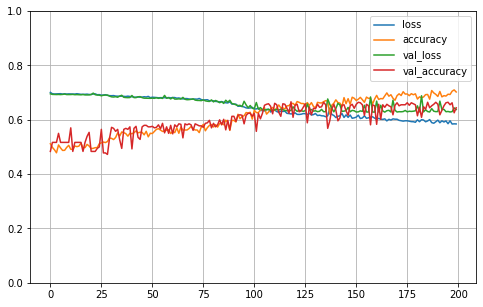


2023-03-28 14:40:19.593918

Testing # 1 1
2023-03-28 14:40:19.594290
2023-03-28 14:40:19.594342
PREDICT
2023-03-28 14:40:19.604211
Test 1:0 280:262 51.66%
Predict 1:0 383:159 70.66%
Test sizes (542, 1025) (542,)
Range of scores: 0.0036634668 to 0.9786642
Score threshold 0.5
Confusion matrix
 [[114 148]
 [ 45 235]]
Normalized matrix
 [[0.2103321  0.27306273]
 [0.08302583 0.43357934]]


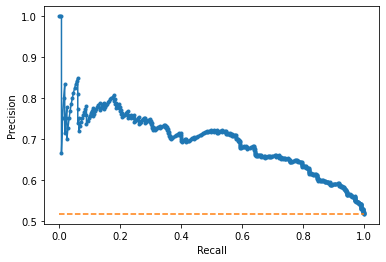

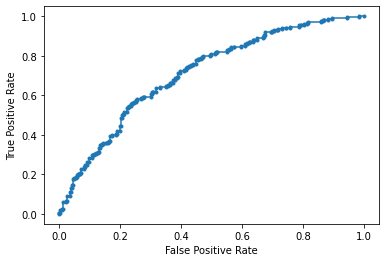

Accuracy: 64.39% Precision: 61.36% Recall: 83.93%
F1: 70.89% MCC: 0.3012
AUPRC: 69.44% AUROC: 71.12%
 accuracy [64.39114391143912]
 precision [61.35770234986945]
 recall [83.92857142857143]
 F1 [70.88989441930619]
 MCC [0.30117308974261636]
 AUPRC [69.4396250354213]
 AUROC [71.11777535441657]
2023-03-28 14:40:20.204945

Training # 1 2
2023-03-28 14:40:20.206316
2023-03-28 14:40:20.206577
Discriminator ZERO -1
Train 1:0 1074:1030 51.05%
Computed class weights: {0: 1.021359223300971, 1: 0.9795158286778398}
Valid 1:0 249:263 48.63%
FIT
2023-03-28 14:40:20.275565


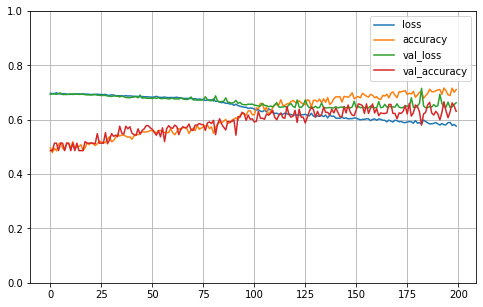


2023-03-28 14:41:19.408612

Testing # 1 2
2023-03-28 14:41:19.408762
2023-03-28 14:41:19.408816
PREDICT
2023-03-28 14:41:19.417179
Test 1:0 249:263 48.63%
Predict 1:0 370:142 72.27%
Test sizes (512, 1025) (512,)
Range of scores: 0.005294843 to 0.9850903
Score threshold 0.5
Confusion matrix
 [[108 155]
 [ 34 215]]
Normalized matrix
 [[0.2109375  0.30273438]
 [0.06640625 0.41992188]]


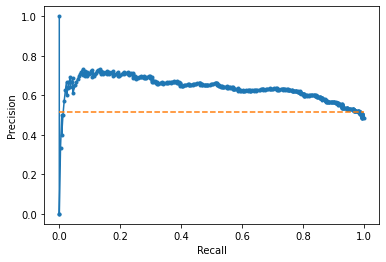

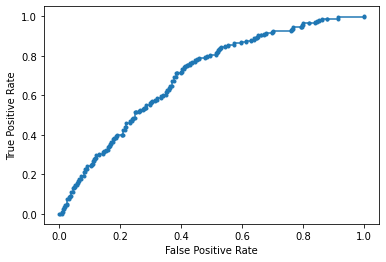

Accuracy: 63.09% Precision: 58.11% Recall: 86.35%
F1: 69.47% MCC: 0.3060
AUPRC: 63.79% AUROC: 69.86%
 accuracy [63.0859375]
 precision [58.108108108108105]
 recall [86.34538152610442]
 F1 [69.46688206785137]
 MCC [0.3060144052906469]
 AUPRC [63.79136071524889]
 AUROC [69.85966680409852]
2023-03-28 14:41:20.019560

Training # 1 3
2023-03-28 14:41:20.021194
2023-03-28 14:41:20.021275
Discriminator ZERO -1
Train 1:0 1066:1034 50.76%
Computed class weights: {0: 1.0154738878143132, 1: 0.9849906191369606}
Valid 1:0 257:259 49.81%
FIT
2023-03-28 14:41:20.108123


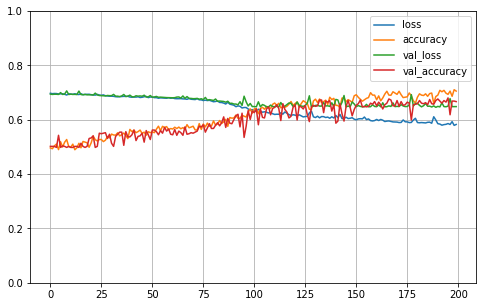


2023-03-28 14:42:18.579817

Testing # 1 3
2023-03-28 14:42:18.581964
2023-03-28 14:42:18.582400
PREDICT
2023-03-28 14:42:18.589162
Test 1:0 257:259 49.81%
Predict 1:0 299:217 57.95%
Test sizes (516, 1025) (516,)
Range of scores: 0.0063429205 to 0.9821549
Score threshold 0.5
Confusion matrix
 [[152 107]
 [ 65 192]]
Normalized matrix
 [[0.29457364 0.20736434]
 [0.12596899 0.37209302]]


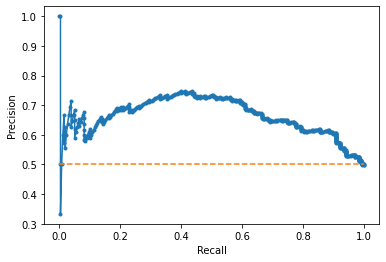

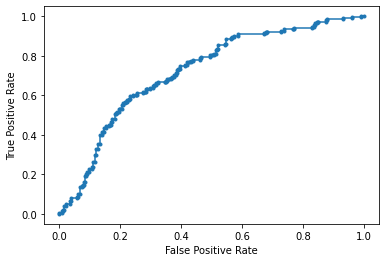

Accuracy: 66.67% Precision: 64.21% Recall: 74.71%
F1: 69.06% MCC: 0.3383
AUPRC: 66.37% AUROC: 72.16%
 accuracy [66.66666666666666]
 precision [64.21404682274247]
 recall [74.70817120622569]
 F1 [69.06474820143885]
 MCC [0.33825016806266534]
 AUPRC [66.36848210391531]
 AUROC [72.16471613358773]
2023-03-28 14:42:19.441999

Training # 1 4
2023-03-28 14:42:19.442253
2023-03-28 14:42:19.442313
Discriminator ZERO -1
Train 1:0 1055:1041 50.33%
Computed class weights: {0: 1.0067243035542748, 1: 0.9933649289099526}
Valid 1:0 268:252 51.54%
FIT
2023-03-28 14:42:19.550521


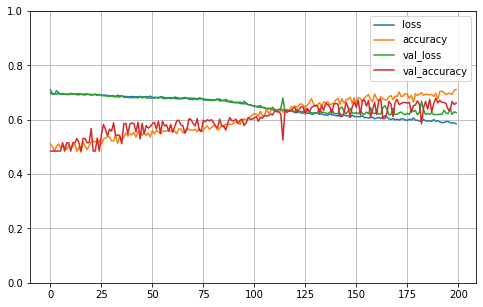


2023-03-28 14:43:43.180288

Testing # 1 4
2023-03-28 14:43:43.180678
2023-03-28 14:43:43.180749
PREDICT
2023-03-28 14:43:43.190883
Test 1:0 268:252 51.54%
Predict 1:0 216:304 41.54%
Test sizes (520, 1025) (520,)
Range of scores: 0.005939569 to 0.9534246
Score threshold 0.5
Confusion matrix
 [[190  62]
 [114 154]]
Normalized matrix
 [[0.36538462 0.11923077]
 [0.21923077 0.29615385]]


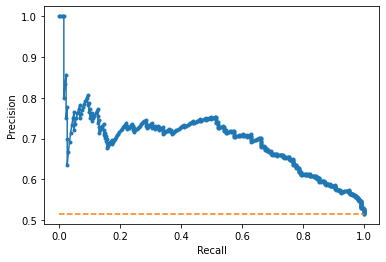

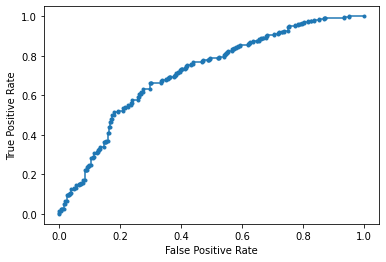

Accuracy: 66.15% Precision: 71.30% Recall: 57.46%
F1: 63.64% MCC: 0.3332
AUPRC: 69.35% AUROC: 71.52%
 accuracy [66.15384615384615]
 precision [71.29629629629629]
 recall [57.46268656716418]
 F1 [63.63636363636365]
 MCC [0.3332461256318946]
 AUPRC [69.35411027220519]
 AUROC [71.52481639421939]
2023-03-28 14:43:43.788611

Training # 1 5
2023-03-28 14:43:43.788858
2023-03-28 14:43:43.790937
Discriminator ZERO -1
Train 1:0 1054:1036 50.43%
Computed class weights: {0: 1.0086872586872586, 1: 0.99146110056926}
Valid 1:0 269:257 51.14%
FIT
2023-03-28 14:43:43.865498


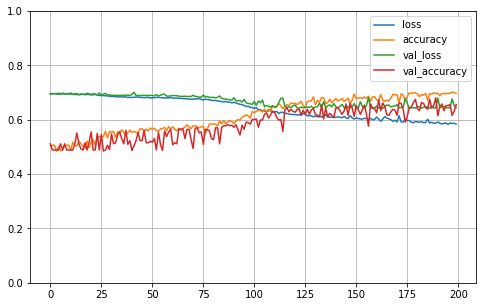


2023-03-28 14:45:07.091167

Testing # 1 5
2023-03-28 14:45:07.091295
2023-03-28 14:45:07.091341
PREDICT
2023-03-28 14:45:07.101083
Test 1:0 269:257 51.14%
Predict 1:0 312:214 59.32%
Test sizes (526, 1025) (526,)
Range of scores: 0.0036989036 to 0.9886832
Score threshold 0.5
Confusion matrix
 [[145 112]
 [ 69 200]]
Normalized matrix
 [[0.2756654  0.21292776]
 [0.13117871 0.38022814]]


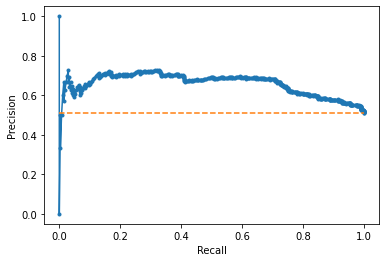

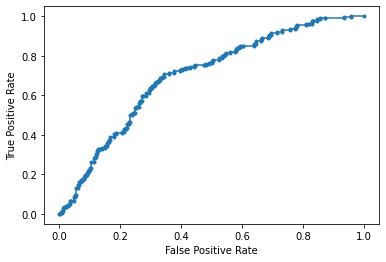

Accuracy: 65.59% Precision: 64.10% Recall: 74.35%
F1: 68.85% MCC: 0.3131
AUPRC: 65.78% AUROC: 70.01%
 accuracy [65.5893536121673]
 precision [64.1025641025641]
 recall [74.34944237918215]
 F1 [68.84681583476764]
 MCC [0.31309882584853305]
 AUPRC [65.78036971738877]
 AUROC [70.0056413001027]
2023-03-28 14:45:07.700864

Training # 2 1
2023-03-28 14:45:07.701045
2023-03-28 14:45:07.701102
Discriminator ZERO -1
Train 1:0 1049:1035 50.34%
Computed class weights: {0: 1.0067632850241546, 1: 0.9933269780743565}
Valid 1:0 274:258 51.50%
FIT
2023-03-28 14:45:07.774734


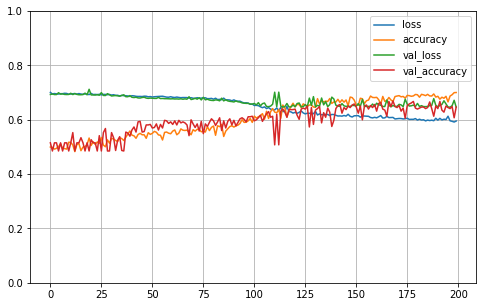


2023-03-28 14:46:02.202648

Testing # 2 1
2023-03-28 14:46:02.202797
2023-03-28 14:46:02.202845
PREDICT
2023-03-28 14:46:02.212126
Test 1:0 274:258 51.50%
Predict 1:0 296:236 55.64%
Test sizes (532, 1025) (532,)
Range of scores: 0.018963305 to 0.98488957
Score threshold 0.5
Confusion matrix
 [[153 105]
 [ 83 191]]
Normalized matrix
 [[0.28759398 0.19736842]
 [0.15601504 0.35902256]]


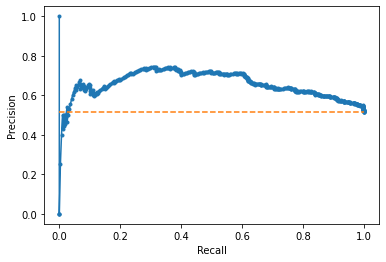

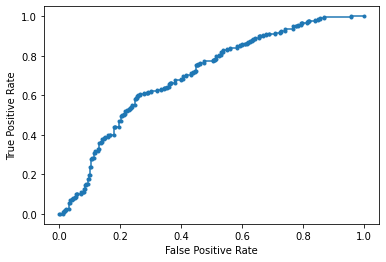

Accuracy: 64.66% Precision: 64.53% Recall: 69.71%
F1: 67.02% MCC: 0.2918
AUPRC: 65.44% AUROC: 70.22%
 accuracy [64.66165413533834]
 precision [64.52702702702703]
 recall [69.7080291970803]
 F1 [67.01754385964914]
 MCC [0.2918342886508036]
 AUPRC [65.435034675546]
 AUROC [70.22435353363889]
2023-03-28 14:46:02.781991

Training # 2 2
2023-03-28 14:46:02.784128
2023-03-28 14:46:02.784212
Discriminator ZERO -1
Train 1:0 1062:1030 50.76%
Computed class weights: {0: 1.0155339805825243, 1: 0.9849340866290018}
Valid 1:0 261:263 49.81%
FIT
2023-03-28 14:46:02.850740


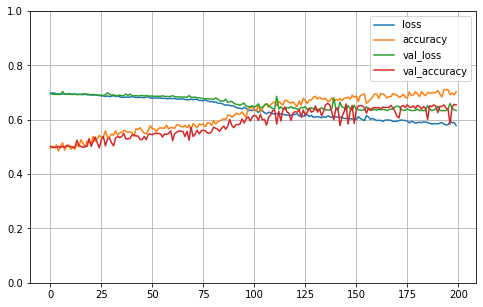


2023-03-28 14:47:25.999709

Testing # 2 2
2023-03-28 14:47:26.000197
2023-03-28 14:47:26.000240
PREDICT
2023-03-28 14:47:26.010264
Test 1:0 261:263 49.81%
Predict 1:0 302:222 57.63%
Test sizes (524, 1025) (524,)
Range of scores: 0.0057441727 to 0.9748246
Score threshold 0.5
Confusion matrix
 [[152 111]
 [ 70 191]]
Normalized matrix
 [[0.29007634 0.21183206]
 [0.13358779 0.36450382]]


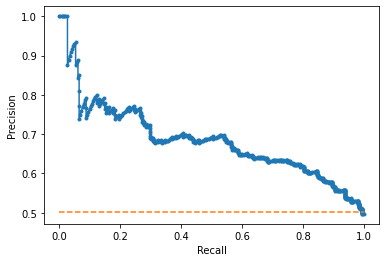

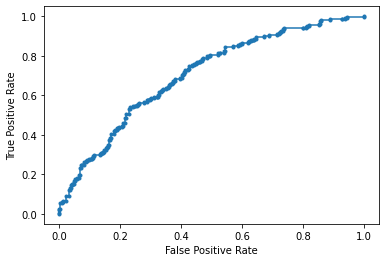

Accuracy: 65.46% Precision: 63.25% Recall: 73.18%
F1: 67.85% MCC: 0.3134
AUPRC: 68.50% AUROC: 70.42%
 accuracy [65.45801526717557]
 precision [63.24503311258278]
 recall [73.18007662835248]
 F1 [67.85079928952042]
 MCC [0.3134195099249029]
 AUPRC [68.49524949346642]
 AUROC [70.42087321358332]
2023-03-28 14:47:27.141010

Training # 2 3
2023-03-28 14:47:27.141887
2023-03-28 14:47:27.141962
Discriminator ZERO -1
Train 1:0 1047:1051 49.90%
Computed class weights: {0: 0.9980970504281637, 1: 1.0019102196752627}
Valid 1:0 276:242 53.28%
FIT
2023-03-28 14:47:27.215727


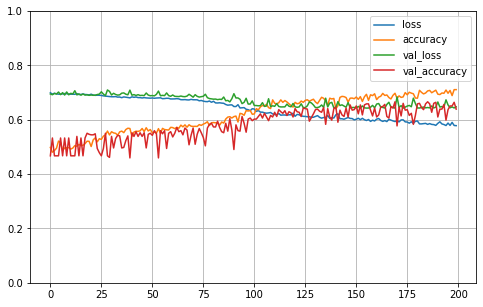


2023-03-28 14:48:23.415362

Testing # 2 3
2023-03-28 14:48:23.417331
2023-03-28 14:48:23.417802
PREDICT
2023-03-28 14:48:23.423257
Test 1:0 276:242 53.28%
Predict 1:0 363:155 70.08%
Test sizes (518, 1025) (518,)
Range of scores: 0.0020940588 to 0.9813402
Score threshold 0.5
Confusion matrix
 [[105 137]
 [ 50 226]]
Normalized matrix
 [[0.2027027  0.26447876]
 [0.0965251  0.43629344]]


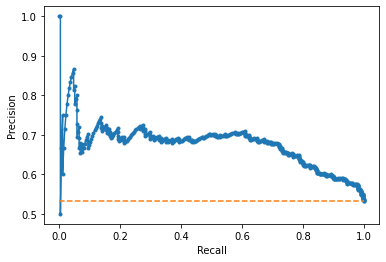

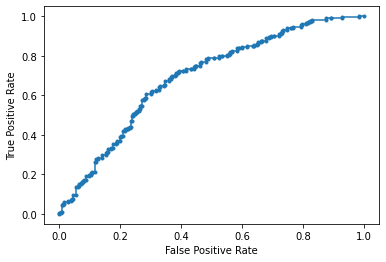

Accuracy: 63.90% Precision: 62.26% Recall: 81.88%
F1: 70.74% MCC: 0.2754
AUPRC: 67.62% AUROC: 69.05%
 accuracy [63.899613899613904]
 precision [62.25895316804407]
 recall [81.88405797101449]
 F1 [70.73552425665102]
 MCC [0.2753537888130525]
 AUPRC [67.62142320762614]
 AUROC [69.04719128039287]
2023-03-28 14:48:24.046310

Training # 2 4
2023-03-28 14:48:24.047978
2023-03-28 14:48:24.048049
Discriminator ZERO -1
Train 1:0 1068:1024 51.05%
Computed class weights: {0: 1.021484375, 1: 0.9794007490636704}
Valid 1:0 255:269 48.66%
FIT
2023-03-28 14:48:24.118080


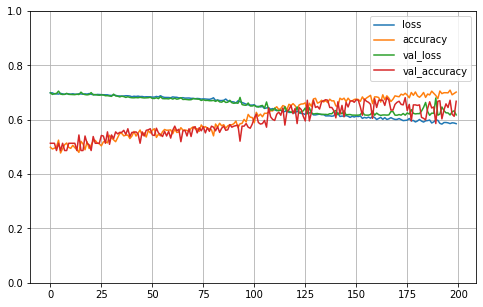


2023-03-28 14:49:21.097374

Testing # 2 4
2023-03-28 14:49:21.097734
2023-03-28 14:49:21.097800
PREDICT
2023-03-28 14:49:21.104871
Test 1:0 255:269 48.66%
Predict 1:0 251:273 47.90%
Test sizes (524, 1025) (524,)
Range of scores: 0.0021428773 to 0.9573393
Score threshold 0.5
Confusion matrix
 [[184  85]
 [ 89 166]]
Normalized matrix
 [[0.35114504 0.16221374]
 [0.16984733 0.31679389]]


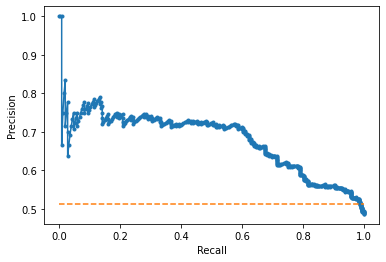

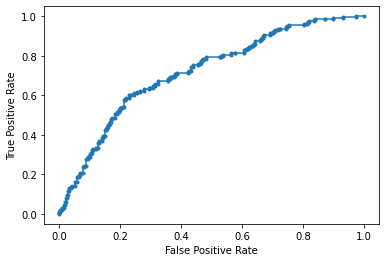

Accuracy: 66.79% Precision: 66.14% Recall: 65.10%
F1: 65.61% MCC: 0.3352
AUPRC: 67.92% AUROC: 71.93%
 accuracy [66.79389312977099]
 precision [66.13545816733067]
 recall [65.09803921568627]
 F1 [65.61264822134387]
 MCC [0.33517121264811867]
 AUPRC [67.9243050271036]
 AUROC [71.92798308914644]
2023-03-28 14:49:22.048898

Training # 2 5
2023-03-28 14:49:22.051210
2023-03-28 14:49:22.051615
Discriminator ZERO -1
Train 1:0 1066:1032 50.81%
Computed class weights: {0: 1.0164728682170543, 1: 0.9840525328330206}
Valid 1:0 257:261 49.61%
FIT
2023-03-28 14:49:22.142358


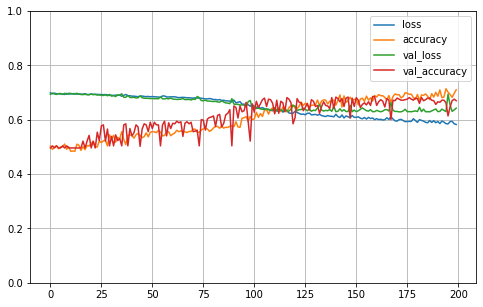


2023-03-28 14:50:45.801949

Testing # 2 5
2023-03-28 14:50:45.802039
2023-03-28 14:50:45.802076
PREDICT
2023-03-28 14:50:45.807135
Test 1:0 257:261 49.61%
Predict 1:0 358:160 69.11%
Test sizes (518, 1025) (518,)
Range of scores: 0.0044251587 to 0.9898085
Score threshold 0.5
Confusion matrix
 [[125 136]
 [ 35 222]]
Normalized matrix
 [[0.24131274 0.26254826]
 [0.06756757 0.42857143]]


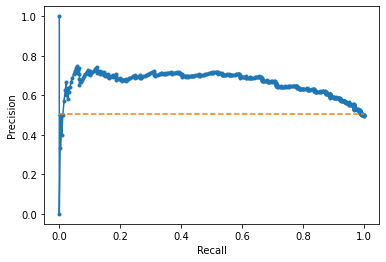

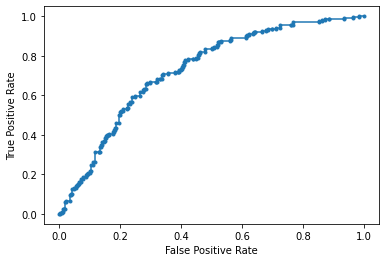

Accuracy: 66.99% Precision: 62.01% Recall: 86.38%
F1: 72.20% MCC: 0.3709
AUPRC: 66.64% AUROC: 72.78%
 accuracy [66.98841698841699]
 precision [62.01117318435754]
 recall [86.38132295719845]
 F1 [72.1951219512195]
 MCC [0.37089472039387433]
 AUPRC [66.64143401199432]
 AUROC [72.77904497815942]
2023-03-28 14:50:46.418910


In [57]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [58]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 65.37% std 1.33
 precision mean 63.73% std 3.44
 recall mean 75.30% std 9.56
 F1 mean 68.53% std 2.59
 MCC mean 0.32% std 0.03
 AUPRC mean 67.09% std 1.82
 AUROC mean 70.91% std 1.18
 accuracy [[64.39114391143912], [63.0859375], [66.66666666666666], [66.15384615384615], [65.5893536121673], [64.66165413533834], [65.45801526717557], [63.899613899613904], [66.79389312977099], [66.98841698841699]]
 precision [[61.35770234986945], [58.108108108108105], [64.21404682274247], [71.29629629629629], [64.1025641025641], [64.52702702702703], [63.24503311258278], [62.25895316804407], [66.13545816733067], [62.01117318435754]]
 recall [[83.92857142857143], [86.34538152610442], [74.70817120622569], [57.46268656716418], [74.34944237918215], [69.7080291970803], [73.18007662835248], [81.88405797101449], [65.09803921568627], [86.38132295719845]]
 F1 [[70.88989441930619], [69.46688206785137], [69.06474820143885], [63.63636363636365], [68.84681583476764], [67.01754385964914], [67.8507992895204